#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential , Model
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')
featurse = pd.read_csv(path + 'features.csv')

In [ ]:
data01_train.drop('subject',axis=1,inplace=True)
data01_test.drop('subject',axis=1,inplace=True)

#### 2) 기본 정보 조회

In [ ]:
data01_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
data01_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [ ]:
data01_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
x=data01_train.drop('Activity',axis=1)
y=data01_train.loc[:,'Activity']

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
y = y.map({'STANDING': 0 ,'LAYING':1,'SITTING':2,'WALKING_DOWNSTAIRS':3,'WALKING_UPSTAIRS':4,'WALKING':5})

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=72)

### (2) 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

In [ ]:
result = {}

### (1) 모델1

In [ ]:
nfeatures = x_train.shape[1]


In [ ]:
model1 = Sequential([Input(shape=(nfeatures,)) , Dense(6, activation='softmax')])
model1.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clear_session()
history1 = model1.fit(x_train,y_train,epochs=100 , validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.8554 - val_loss: 1.5314
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4802 - val_loss: 1.3210
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2962 - val_loss: 1.1952
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1783 - val_loss: 1.1059
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0950 - val_loss: 1.0378
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0276 - val_loss: 0.9800
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9697 - val_loss: 0.9332
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9295 - val_loss: 0.8902
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8877 - val_loss: 0.8527
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8535 - val_loss: 0.8191
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8108 - val_loss: 0.7884
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━━

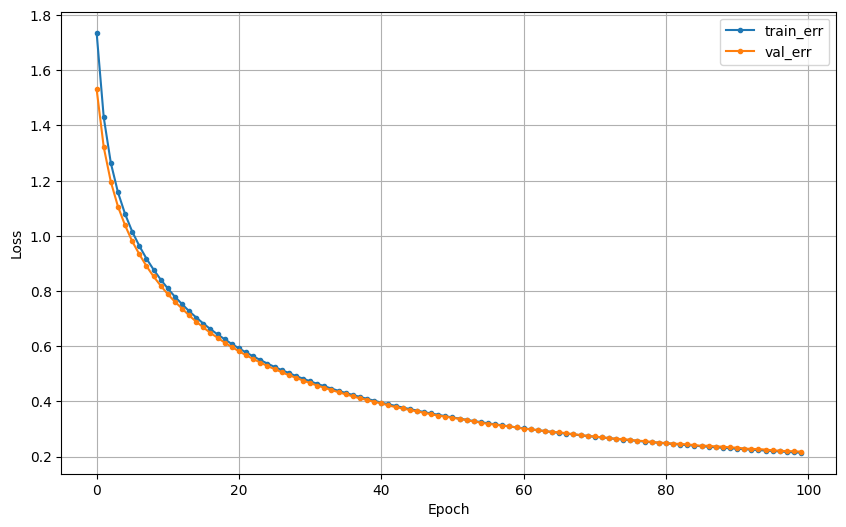

In [ ]:
dl_history_plot(history1)

In [ ]:
pred1 = model1.predict(x_test)
pred1 = pred1.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
print(confusion_matrix(y_test,pred1))
print(classification_report(y_test,pred1))

[[196   0  14   0   0   0]
 [  0 207   0   0   0   0]
 [ 48   1 174   0   0   0]
 [  0   0   0 167   3   4]
 [  0   0   0   5 154   4]
 [  0   0   0   2   5 193]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       210
           1       1.00      1.00      1.00       207
           2       0.93      0.78      0.85       223
           3       0.96      0.96      0.96       174
           4       0.95      0.94      0.95       163
           5       0.96      0.96      0.96       200

    accuracy                           0.93      1177
   macro avg       0.93      0.93      0.93      1177
weighted avg       0.93      0.93      0.93      1177



In [ ]:
result['model1'] = accuracy_score(y_test,pred1)

### (2) 모델2

In [ ]:
clear_session()
model2 = Sequential([Input(shape=(nfeatures,)), Dense(512,activation='relu'), Dense(256,activation='relu'), Dense(128,activation='relu')
                    , Dense(64,activation='relu'), Dense(32,activation='relu'), Dense(16,activation='relu'), Dense(6,activation='softmax')])
model2.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,934 (1.77 MB)

 Trainable params: 462,934 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = model2.fit(x_train,y_train,epochs=100 , validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 201ms/step - loss: 1.5824 - val_loss: 1.0180
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8836 - val_loss: 0.5872
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5085 - val_loss: 0.3490
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2979 - val_loss: 0.2522
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2233 - val_loss: 0.2016
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1698 - val_loss: 0.2166
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1479 - val_loss: 0.1324
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1447 - val_loss: 0.1204
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1239 - val_loss: 0.1154
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1053 - val_loss: 0.1114
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1026 - val_loss: 0.1256
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━

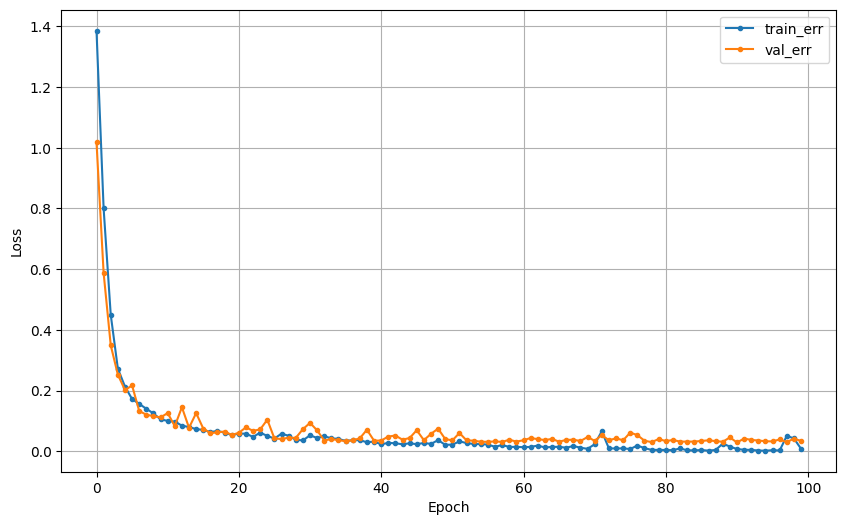

In [ ]:
dl_history_plot(history2)

In [ ]:
pred2 = model2.predict(x_test)
pred2 = pred2.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
print(confusion_matrix(y_test,pred2))
print(classification_report(y_test,pred2))

[[196   0  14   0   0   0]
 [  0 207   0   0   0   0]
 [  6   0 217   0   0   0]
 [  0   0   0 174   0   0]
 [  0   0   0   1 162   0]
 [  0   0   0   0   0 200]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       210
           1       1.00      1.00      1.00       207
           2       0.94      0.97      0.96       223
           3       0.99      1.00      1.00       174
           4       1.00      0.99      1.00       163
           5       1.00      1.00      1.00       200

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
result['model2'] = accuracy_score(y_test,pred2)

In [ ]:
result

{'model1': 0.9269328802039083, 'model2': 0.9821580288870009}

### (3) 모델3

In [ ]:
clear_session()
model3 = Sequential([Input(shape=(nfeatures,)), Dense(2048,activation='relu'), Dense(1024,activation='relu'), Dense(512,activation='relu')
                    , Dense(128,activation='relu'), Dense(64,activation='relu'), Dense(32,activation='relu'),Dense(16,activation='relu'),Dense(6,activation='relu'), Dense(6,activation='softmax')])
model3.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2048)                │       1,150,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,850,624 (14.69 MB)

 Trainable params: 3,850,624 (14.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = model3.fit(x_train,y_train,epochs=30 , validation_split=0.2).history

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - loss: 1.6403 - val_loss: 1.3371
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2940 - val_loss: 1.2496
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2143 - val_loss: 1.2233
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1826 - val_loss: 1.1774
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1567 - val_loss: 1.1317
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1228 - val_loss: 1.1004
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1233 - val_loss: 1.0447
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9590 - val_loss: 0.9554
Epoch 9/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9026 - val_loss: 0.9081
Epoch 10/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8790 - val_loss: 0.9048
Epoch 11/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8359 - val_loss: 0.9201
Epoch 12/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

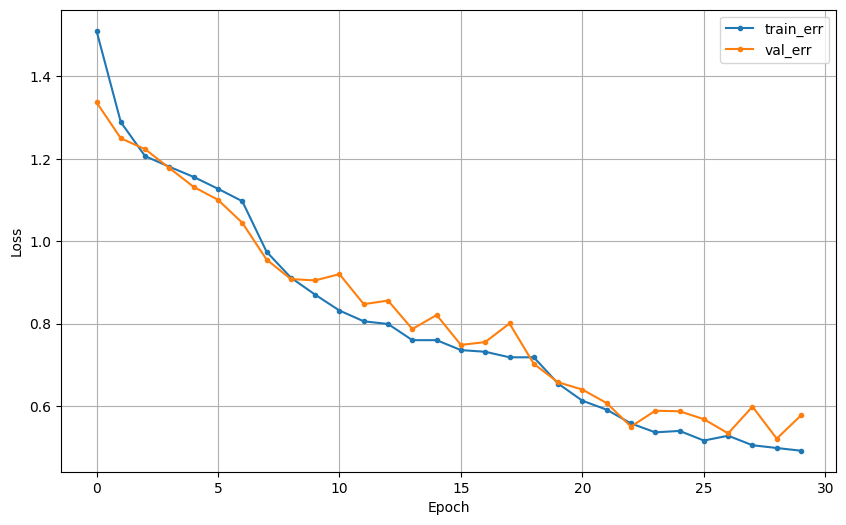

In [ ]:
dl_history_plot(history3)

In [ ]:
pred3 = model3.predict(x_test)
pred3 = pred3.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [ ]:
print(confusion_matrix(y_test,pred3))
print(classification_report(y_test,pred3))

[[205   0   5   0   0   0]
 [  0 207   0   0   0   0]
 [ 29   0 194   0   0   0]
 [  0   0   0   0   0 174]
 [  0   1   3   0 139  20]
 [  0   0   0   0   0 200]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.92       210
           1       1.00      1.00      1.00       207
           2       0.96      0.87      0.91       223
           3       0.00      0.00      0.00       174
           4       1.00      0.85      0.92       163
           5       0.51      1.00      0.67       200

    accuracy                           0.80      1177
   macro avg       0.72      0.78      0.74      1177
weighted avg       0.74      0.80      0.76      1177



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
result['model3'] = accuracy_score(y_test,pred3)

In [ ]:
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617}

### (4) 모델4

In [ ]:
clear_session()
model4 = Sequential([Input(shape=(nfeatures,)), Dense(512,activation='relu')
                    , Dense(256,activation='relu'), Dense(128,activation='relu'), Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(16,activation='relu')
                    ,Dense(8,activation='relu'), Dense(6,activation='softmax')])
model4.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,022 (1.77 MB)

 Trainable params: 463,022 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ae = EarlyStopping(monitor='val_loss',patience=5, min_delta = 0.001)

history4 = model4.fit(x_train,y_train,epochs=100 , validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - loss: 1.6655 - val_loss: 1.3330
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2424 - val_loss: 1.0729
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0117 - val_loss: 0.9015
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8466 - val_loss: 0.7642
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7324 - val_loss: 0.6387
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6064 - val_loss: 0.5608
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5140 - val_loss: 0.4821
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4952 - val_loss: 0.4342
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4202 - val_loss: 0.3951
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3839 - val_loss: 0.3414
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3719 - val_loss: 0.3367
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━

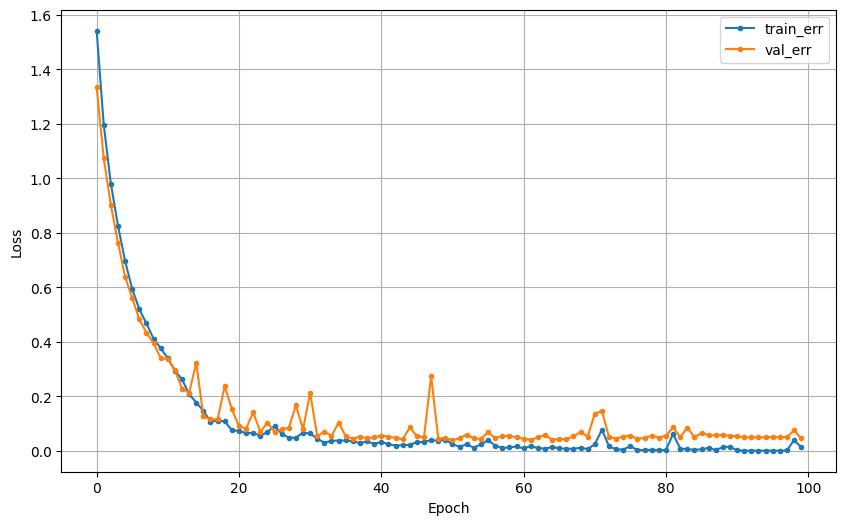

In [ ]:
dl_history_plot(history4)

In [ ]:
pred4 = model4.predict(x_test)
pred4 = pred4.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
print(confusion_matrix(y_test,pred4))
print(classification_report(y_test,pred4))

[[204   0   6   0   0   0]
 [  0 207   0   0   0   0]
 [ 10   0 213   0   0   0]
 [  0   0   0 172   1   1]
 [  0   0   0   0 161   2]
 [  0   0   0   1   1 198]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       210
           1       1.00      1.00      1.00       207
           2       0.97      0.96      0.96       223
           3       0.99      0.99      0.99       174
           4       0.99      0.99      0.99       163
           5       0.99      0.99      0.99       200

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
result['model4'] = accuracy_score(y_test,pred4)
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617,
 'model4': 0.9813084112149533}

### (5) 모델5

In [ ]:
clear_session()
model5 = Sequential([Input(shape=(nfeatures,)),
                    Dense(128,activation='relu'), Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(16,activation='relu')
                    ,Dense(8,activation='relu'), Dense(6,activation='softmax')])
model5.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ae = EarlyStopping(monitor='val_loss',patience=5, min_delta = 0.001)

history5 = model5.fit(x_train,y_train,epochs=100 , validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - loss: 1.6562 - val_loss: 1.3300
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2224 - val_loss: 1.1009
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0398 - val_loss: 0.9673
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8819 - val_loss: 0.8074
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7537 - val_loss: 0.6904
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6494 - val_loss: 0.5706
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5305 - val_loss: 0.4702
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4289 - val_loss: 0.4011
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3558 - val_loss: 0.3424
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3233 - val_loss: 0.2960
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2715 - val_loss: 0.2560
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━

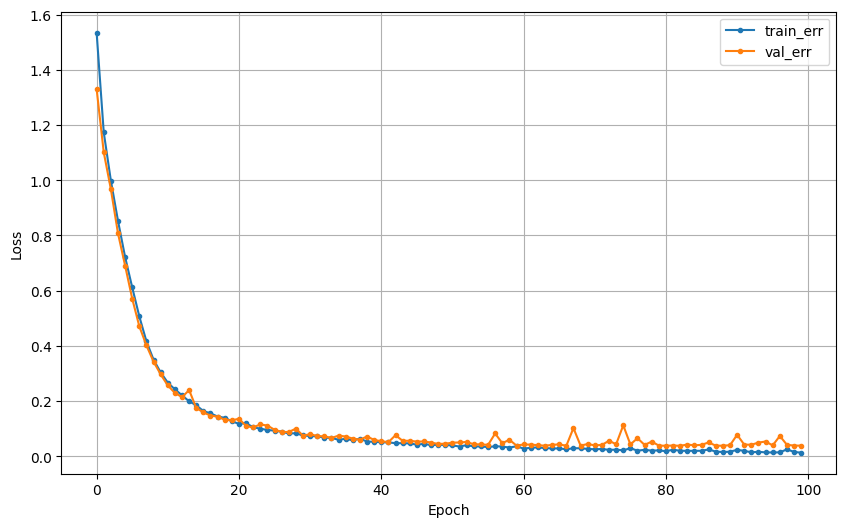

In [ ]:
dl_history_plot(history5)

In [ ]:
pred5 = model5.predict(x_test)
pred5 = pred5.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
print(confusion_matrix(y_test,pred5))
print(classification_report(y_test,pred5))

[[201   0   9   0   0   0]
 [  0 207   0   0   0   0]
 [ 11   0 212   0   0   0]
 [  0   0   0 174   0   0]
 [  0   0   0   1 161   1]
 [  0   0   0   0   0 200]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       210
           1       1.00      1.00      1.00       207
           2       0.96      0.95      0.95       223
           3       0.99      1.00      1.00       174
           4       1.00      0.99      0.99       163
           5       1.00      1.00      1.00       200

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
result['model5'] = accuracy_score(y_test,pred5)
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617,
 'model4': 0.9813084112149533,
 'model5': 0.9813084112149533}

### (6) 모델6

#### 변수 중요도 상위 100개만 추출해서 학습해보기(머신러닝에서 추출)

In [ ]:
# fi_temp = pd.read_csv(path + 'fi_temp.csv')

In [ ]:
fi_temp = pd.read_excel(path + 'fi_temp.xlsx')

In [ ]:
fi_temp_best100 = fi_temp[:100]
fi_temp_best100
fi_temp_name = fi_temp_best100['feature_name']
x_b100 = data01_train.loc[:,fi_temp_name]


In [ ]:
x_train_b100,x_test_b100,y_train_b100,y_test_b100 = train_test_split(x,y,test_size=0.2,random_state=72)

In [ ]:
scaler = MinMaxScaler()
x_train_b100 = scaler.fit_transform(x_train_b100)
x_test_b100 = scaler.transform(x_test_b100)

In [ ]:
nfeatures_b100 = x_train_b100.shape[1]

In [ ]:
clear_session()
model6 = Sequential([Input(shape=(nfeatures,)),Dense(512,activation='relu'),Dense(256,activation='relu'),
                    Dense(128,activation='relu'), Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(16,activation='relu')
                    ,Dense(8,activation='relu'), Dense(6,activation='softmax')])
model6.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,022 (1.77 MB)

 Trainable params: 463,022 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ae = EarlyStopping(monitor='val_loss',patience=5, min_delta = 0.001)

history6 = model6.fit(x_train,y_train,epochs=100 , validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 237ms/step - loss: 1.5997 - val_loss: 1.3241
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.2314 - val_loss: 0.9533
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8496 - val_loss: 0.6025
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5484 - val_loss: 0.4198
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4044 - val_loss: 0.3520
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2993 - val_loss: 0.2759
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2652 - val_loss: 0.2532
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2419 - val_loss: 0.1868
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2182 - val_loss: 0.1722
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1782 - val_loss: 0.1358
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1365 - val_loss: 0.1240
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━

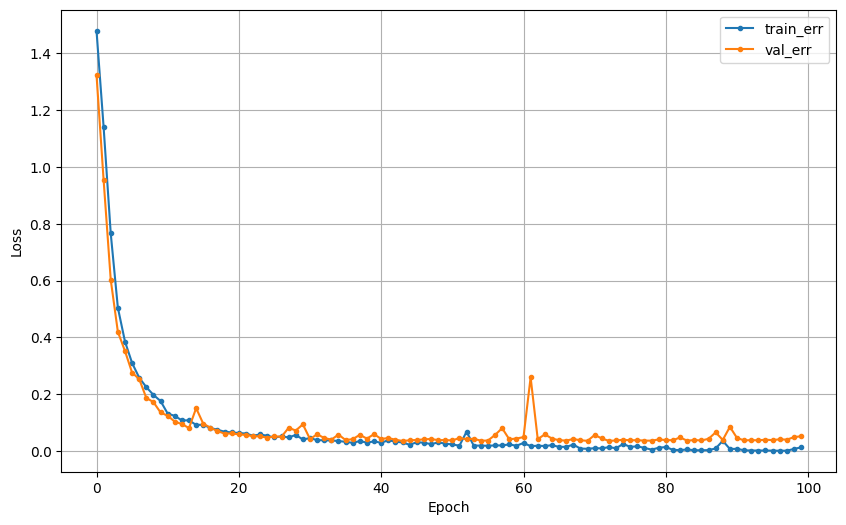

In [ ]:
dl_history_plot(history6)

In [ ]:
pred6 = model6.predict(x_test)
pred6 = pred6.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
print(confusion_matrix(y_test,pred6))
print(classification_report(y_test,pred6))  #변수 중요도 상위 100만 추출해서 학습시켜도 정확도가 크게 떨어지지 않음

[[205   0   4   0   0   1]
 [  0 207   0   0   0   0]
 [ 26   0 197   0   0   0]
 [  0   0   0 174   0   0]
 [  0   0   0   0 159   4]
 [  0   0   0   0   2 198]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       210
           1       1.00      1.00      1.00       207
           2       0.98      0.88      0.93       223
           3       1.00      1.00      1.00       174
           4       0.99      0.98      0.98       163
           5       0.98      0.99      0.98       200

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



In [ ]:
result['model6'] = accuracy_score(y_test,pred6)
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617,
 'model4': 0.9813084112149533,
 'model5': 0.9813084112149533,
 'model6': 0.9685641461342396}

## (7) 모델 7 : 파라미터를 약 7000개 정도로 줄인 모델

In [ ]:
model7 = Sequential()
model7.add(Dense(12, activation='relu', input_shape=(x_train.shape[1],)))
model7.add(Dense(6, activation='softmax'))

model7.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 12)                  │           6,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,822 (26.65 KB)

 Trainable params: 6,822 (26.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history7 = model7.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test)).history

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4480 - loss: 1.4844 - val_accuracy: 0.5981 - val_loss: 1.0719
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6325 - loss: 1.0064 - val_accuracy: 0.7103 - val_loss: 0.8470
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7460 - loss: 0.8049 - val_accuracy: 0.7833 - val_loss: 0.7069
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8166 - loss: 0.6757 - val_accuracy: 0.8343 - val_loss: 0.6188
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8610 - loss: 0.5790 - val_accuracy: 0.8573 - val_loss: 0.5363
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8725 - loss: 0.5090 - val_accuracy: 0.8768 - val_loss: 0.4741
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8853 - loss: 0.4515 - val_accuracy: 0.8879 - val_loss: 0.4243
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9097 - loss: 0.3914 - val_accuracy: 0.8760 - 

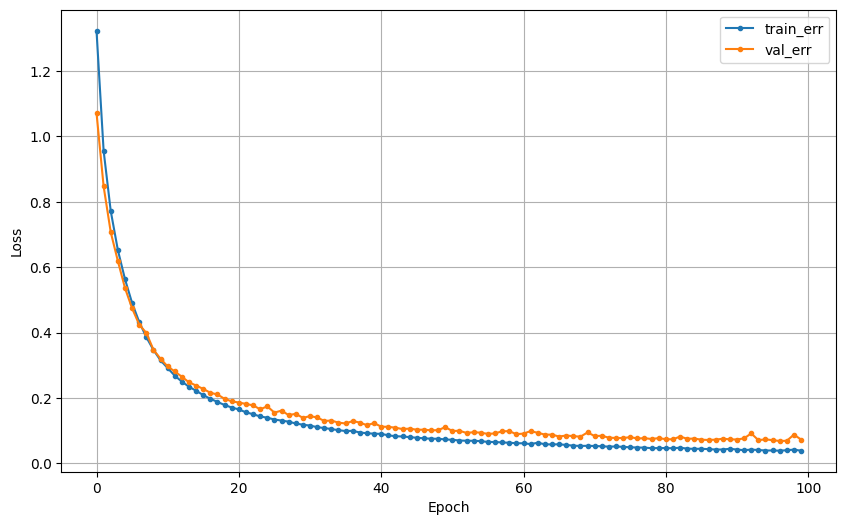

In [ ]:
dl_history_plot(history7)

In [ ]:
pred7 = model7.predict(x_test)
pred7 = pred7.argmax(axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [ ]:
print(confusion_matrix(y_test,pred7))               ##파라미터를 약 7000개로 최소화 하여도 성능이 크게 저하되지 않음
print(classification_report(y_test,pred7))

[[203   0   7   0   0   0]
 [  0 207   0   0   0   0]
 [ 20   0 203   0   0   0]
 [  0   0   0 174   0   0]
 [  0   0   0   0 159   4]
 [  0   0   0   1   1 198]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       210
           1       1.00      1.00      1.00       207
           2       0.97      0.91      0.94       223
           3       0.99      1.00      1.00       174
           4       0.99      0.98      0.98       163
           5       0.98      0.99      0.99       200

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



In [ ]:
result['model7'] = accuracy_score(y_test,pred7)
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617,
 'model4': 0.9813084112149533,
 'model5': 0.9813084112149533,
 'model6': 0.9685641461342396,
 'model7': 0.9719626168224299}

##(8) 모델 8 : dropout 사용

In [ ]:
clear_session()

model8 = Sequential([Input(shape=(nfeatures,)),
                      Dropout(0.2),
                      Dense(512, activation='relu'),
                      Dropout(0.2),
                      Dense(256, activation='relu'),
                      Dropout(0.2),
                      Dense(128, activation='relu'),
                      Dropout(0.2),
                      Dense(64, activation='relu'),
                      Dropout(0.2),
                      Dense(32, activation='relu'),
                      Dropout(0.2),
                      Dense(16, activation='relu'),
                      Dropout(0.2),
                      Dense(6, activation='softmax')])

model8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 561)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,934 (1.77 MB)

 Trainable params: 462,934 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model8.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history8 = model8.fit(x_train, y_train, epochs=50, validation_split=.2).history

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - loss: 1.7920 - val_loss: 1.6868
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.6577 - val_loss: 1.2521
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3663 - val_loss: 1.0191
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2039 - val_loss: 0.8383
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1222 - val_loss: 0.7255
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0139 - val_loss: 0.6107
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9141 - val_loss: 0.5138
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8394 - val_loss: 0.4237
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7981 - val_loss: 0.4069
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7635 - val_loss: 0.3499
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6944 - val_loss: 0.2934
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

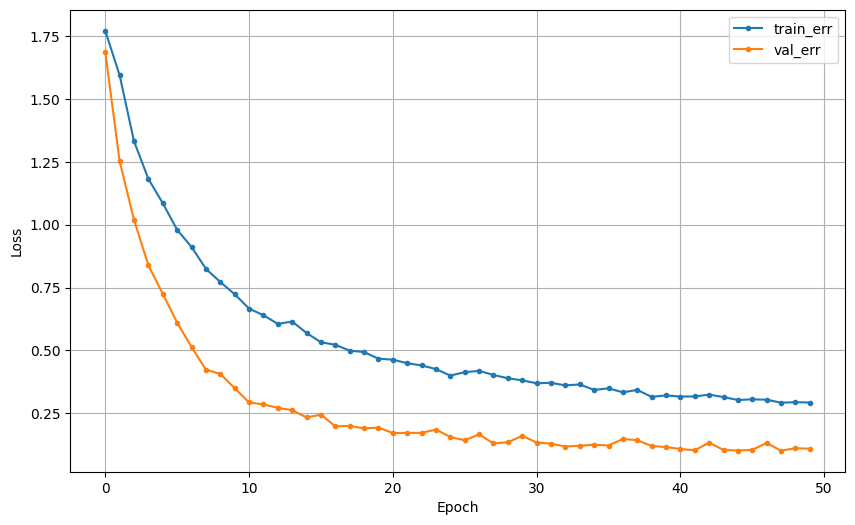

In [ ]:
dl_history_plot(history8)

In [ ]:
pred8 = model8.predict(x_test)
pred8 = pred8.argmax(axis=1)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
print(confusion_matrix(y_test, pred8))
print(classification_report(y_test, pred8))

[[186   0  24   0   0   0]
 [  0 207   0   0   0   0]
 [ 28   0 195   0   0   0]
 [  0   0   0 174   0   0]
 [  0   0   0   5 157   1]
 [  0   0   0   2   1 197]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       210
           1       1.00      1.00      1.00       207
           2       0.89      0.87      0.88       223
           3       0.96      1.00      0.98       174
           4       0.99      0.96      0.98       163
           5       0.99      0.98      0.99       200

    accuracy                           0.95      1177
   macro avg       0.95      0.95      0.95      1177
weighted avg       0.95      0.95      0.95      1177



In [ ]:
result['model8'] = accuracy_score(y_test,pred8)
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617,
 'model4': 0.9813084112149533,
 'model5': 0.9813084112149533,
 'model6': 0.9685641461342396,
 'model7': 0.9719626168224299,
 'model8': 0.9481733220050977}

##(9) 모델 9

In [ ]:
clear_session()

il = Input(shape=(nfeatures,))
hl1 = Dense(512, activation='relu')(il)
hl2 = Dense(256, activation='relu')(hl1)
hl3 = Dense(128, activation='relu')(hl2)
hl4 = Dense(64, activation='relu')(hl3)
hl5 = Dense(32, activation='relu')(hl4)
hl6 = Dense(32, activation='relu')(hl5)
ol = Dense(6, activation='softmax')(hl6)

model9 = Model(inputs=il,outputs=ol)
model9.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

model9.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 561)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,558 (1.77 MB)

 Trainable params: 463,558 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history9= model9.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0).history

In [ ]:
pred9 = model9.predict(x_test)
pred9 = np.argmax(pred9, axis=1)
print(confusion_matrix(y_test, pred9))
print(classification_report(y_test, pred9))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[205   0   5   0   0   0]
 [  0 207   0   0   0   0]
 [ 12   0 211   0   0   0]
 [  0   0   0 174   0   0]
 [  0   0   0   0 159   4]
 [  0   0   0   0   0 200]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       210
           1       1.00      1.00      1.00       207
           2       0.98      0.95      0.96       223
           3       1.00      1.00      1.00       174
           4       1.00      0.98      0.99       163
           5       0.98      1.00      0.99       200

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



In [ ]:
result['model9'] = accuracy_score(y_test,pred9)
result

{'model1': 0.9269328802039083,
 'model2': 0.9821580288870009,
 'model3': 0.8028887000849617,
 'model4': 0.9813084112149533,
 'model5': 0.9813084112149533,
 'model6': 0.9685641461342396,
 'model7': 0.9719626168224299,
 'model8': 0.9481733220050977,
 'model9': 0.9821580288870009}

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
data01_test = pd.read_csv(path + 'data01_test.csv')

In [ ]:
data01_test

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,14,SITTING
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,16,STANDING
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,8,WALKING_DOWNSTAIRS
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,19,LAYING


In [ ]:
x_t=data01_test.drop(['Activity','subject'],axis=1)
y_t=data01_test.loc[:,'Activity']

In [ ]:
sc = MinMaxScaler()
x_t = sc.fit_transform(x_t)

In [ ]:
y_t = y_t.map({'STANDING': 0 ,'LAYING':1,'SITTING':2,'WALKING_DOWNSTAIRS':3,'WALKING_UPSTAIRS':4,'WALKING':5})

In [ ]:
result_test={}

In [ ]:
def model_test(model,num):
  sum=0
  for i in range(1,6):
    pred1_t = model.predict(x_t)
    pred1_t = pred1_t.argmax(axis=1)
    sum += accuracy_score(y_t,pred1_t)

  result_test[f'model{num}'] = sum/5
  result_test



In [ ]:
model_test(model1,1)
model_test(model2,2)
model_test(model3,3)
model_test( model4,4)
model_test(model5,5)
model_test(model6,6)
model_test(model7,7)
model_test(model9,9)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━

In [ ]:
result_test

{'model1': 0.9177430319510537,
 'model2': 0.9741672331747111,
 'model3': 0.7926580557443915,
 'model4': 0.9734874235214142,
 'model5': 0.9660095173351462,
 'model6': 0.9490142760027191,
 'model7': 0.947654656696125,
 'model9': 0.9707681849082256}

In [ ]:
#model6 테스트 결과에서 가장 좋은 성능을 보인

# 추가부분

 - 모델6의 fi_test 파일 불러오기 코드 수정
 - read_csv -> read_excel
 - 파일 확장자 변경

In [ ]:
result_all = []

In [ ]:
def model1_make():
  model1 = Sequential([Input(shape=(nfeatures,)) , Dense(6, activation='softmax')])
  model1.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model1

In [ ]:
def train_model(x_train, y_train, x_t, y_t, model_make):
  model = model_make
  model.fit(x_train, y_train, epochs = 50, verbose=0)
  pred = model.predict(x_t)
  pred = np.argmax(pred, axis = 1)
  return accuracy_score(y_t, pred)

result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model1_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0.8980285520054385, 0.9048266485384092, 0.902787219578518, 0.9048266485384092, 0.9041468388851122]
0.9029231815091775


In [ ]:
print(result_all)

[[0.8980285520054385, 0.9048266485384092, 0.902787219578518, 0.9048266485384092, 0.9041468388851122]]


In [ ]:
def model2_make():
  model2 = Sequential([Input(shape=(nfeatures,)), Dense(512,activation='relu'), Dense(256,activation='relu'), Dense(128,activation='relu')
  , Dense(64,activation='relu'), Dense(32,activation='relu'), Dense(16,activation='relu'), Dense(6,activation='softmax')])
  model2.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')

  return model2

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model2_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[0.9537729435757988, 0.9673691366417403, 0.9748470428280082, 0.9721278042148198, 0.9796057104010877]
0.9695445275322909


In [ ]:
def model3_make():
  model3 = Sequential([Input(shape=(nfeatures,)), Dense(2048,activation='relu'), Dense(1024,activation='relu'), Dense(512,activation='relu'),
                       Dense(128,activation='relu'), Dense(64,activation='relu'), Dense(32,activation='relu'),Dense(16,activation='relu'),Dense(6,activation='relu'), Dense(6,activation='softmax')])
  model3.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model3

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model3_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.972807613868117, 0.9687287559483345, 0.95581237253569, 0.973487423521414, 0.9632902787219578]
0.9668252889191027


In [ ]:
def model4_make():
  model4 = Sequential([Input(shape=(nfeatures,)), Dense(512,activation='relu'),
                       Dense(256,activation='relu'), Dense(128,activation='relu'), Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(16,activation='relu'),
                       Dense(8,activation='relu'), Dense(6,activation='softmax')])
  model4.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model4

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model4_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[0.9721278042148198, 0.9517335146159075, 0.9707681849082257, 0.9755268524813052, 0.9673691366417403]
0.9675050985723997


In [ ]:
def model5_make():
  model5 = Sequential([Input(shape=(nfeatures,)),
                      Dense(128,activation='relu'), Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(16,activation='relu')
                      ,Dense(8,activation='relu'), Dense(6,activation='softmax')])
  model5.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model5

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model5_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[0.9585316111488783, 0.9490142760027193, 0.9666893269884432, 0.9483344663494222, 0.9598912304554724]
0.9564921821889871


In [ ]:
def model6_make():
  model6 = Sequential([Input(shape=(nfeatures,)),Dense(512,activation='relu'),Dense(256,activation='relu'),
                      Dense(128,activation='relu'), Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(16,activation='relu')
                      ,Dense(8,activation='relu'), Dense(6,activation='softmax')])
  model6.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model6

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model6_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.9687287559483345, 0.9666893269884432, 0.9680489462950373, 0.9598912304554724, 0.973487423521414]
0.9673691366417403


In [ ]:
def model7_make():
  model7 = Sequential()
  model7.add(Dense(12, activation='relu', input_shape=(x_train.shape[1],)))
  model7.add(Dense(6, activation='softmax'))
  model7.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model7

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model7_make()))

print(result)
print(np.mean(result))
result_all.append(result)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.9272603670972128, 0.9265805574439157, 0.9286199864038069, 0.9299796057104011, 0.9150237933378654]
0.9254928619986403


In [ ]:
def model8_make():
  model8 = Sequential([Input(shape=(nfeatures,)),
                        Dropout(0.2),
                        Dense(512, activation='relu'),
                        Dropout(0.2),
                        Dense(256, activation='relu'),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dropout(0.2),
                        Dense(64, activation='relu'),
                        Dropout(0.2),
                        Dense(32, activation='relu'),
                        Dropout(0.2),
                        Dense(16, activation='relu'),
                        Dropout(0.2),
                        Dense(6, activation='softmax')])
  model8.compile(optimizer=Adam(learning_rate=0.0001) , loss='sparse_categorical_crossentropy')
  return model8

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model8_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[0.946974847042828, 0.9252209381373215, 0.9490142760027193, 0.9503738953093134, 0.9537729435757988]
0.9450713800135961


In [ ]:
def model9_make():
  il = Input(shape=(nfeatures,))
  hl1 = Dense(512, activation='relu')(il)
  hl2 = Dense(256, activation='relu')(hl1)
  hl3 = Dense(128, activation='relu')(hl2)
  hl4 = Dense(64, activation='relu')(hl3)
  hl5 = Dense(32, activation='relu')(hl4)
  hl6 = Dense(32, activation='relu')(hl5)
  ol = Dense(6, activation='softmax')(hl6)

  model9 = Model(inputs=il,outputs=ol)
  model9.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
  return model9

In [ ]:
result = []
for i in range(5):
    result.append(train_model(x_train, y_train, x_t, y_t, model9_make()))

print(result)
print(np.mean(result))
result_all.append(result)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[0.9564921821889871, 0.9612508497620667, 0.9626104690686608, 0.9632902787219578, 0.972807613868117]
0.9632902787219578


In [ ]:
for i in range(0, len(result_all)):
  print("==========")
  for j in range(0, len(result_all[i])):
    print(f'model{i+1}_{j} : {result_all[i][j]}')

model1_0 : 0.8980285520054385
model1_1 : 0.9048266485384092
model1_2 : 0.902787219578518
model1_3 : 0.9048266485384092
model1_4 : 0.9041468388851122
model2_0 : 0.9537729435757988
model2_1 : 0.9673691366417403
model2_2 : 0.9748470428280082
model2_3 : 0.9721278042148198
model2_4 : 0.9796057104010877
model3_0 : 0.972807613868117
model3_1 : 0.9687287559483345
model3_2 : 0.95581237253569
model3_3 : 0.973487423521414
model3_4 : 0.9632902787219578
model4_0 : 0.9721278042148198
model4_1 : 0.9517335146159075
model4_2 : 0.9707681849082257
model4_3 : 0.9755268524813052
model4_4 : 0.9673691366417403
model5_0 : 0.9585316111488783
model5_1 : 0.9490142760027193
model5_2 : 0.9666893269884432
model5_3 : 0.9483344663494222
model5_4 : 0.9598912304554724
model6_0 : 0.9687287559483345
model6_1 : 0.9666893269884432
model6_2 : 0.9680489462950373
model6_3 : 0.9598912304554724
model6_4 : 0.973487423521414
model7_0 : 0.9272603670972128
model7_1 : 0.9265805574439157
model7_2 : 0.9286199864038069
model7_3 : 0.929

In [ ]:
print("모델 별 예측 평균값")
for i in range(0, len(result_all)):
  print(f'model{i+1} : {np.mean(result_all[i])}')

모델 별 예측 평균값
model1 : 0.9029231815091775
모델 별 예측 평균값
model2 : 0.9695445275322909
모델 별 예측 평균값
model3 : 0.9668252889191027
모델 별 예측 평균값
model4 : 0.9675050985723997
모델 별 예측 평균값
model5 : 0.9564921821889871
모델 별 예측 평균값
model6 : 0.9673691366417403
모델 별 예측 평균값
model7 : 0.9254928619986403
모델 별 예측 평균값
model8 : 0.9450713800135961
모델 별 예측 평균값
model9 : 0.9632902787219578


In [1]:
import pandas as pd

# 모델 별 예측 결과를 딕셔너리로 저장
data = {
    'model': ['model1_0', 'model1_1', 'model1_2', 'model1_3', 'model1_4',
              'model2_0', 'model2_1', 'model2_2', 'model2_3', 'model2_4',
              'model3_0', 'model3_1', 'model3_2', 'model3_3', 'model3_4',
              'model4_0', 'model4_1', 'model4_2', 'model4_3', 'model4_4',
              'model5_0', 'model5_1', 'model5_2', 'model5_3', 'model5_4',
              'model6_0', 'model6_1', 'model6_2', 'model6_3', 'model6_4',
              'model7_0', 'model7_1', 'model7_2', 'model7_3', 'model7_4',
              'model8_0', 'model8_1', 'model8_2', 'model8_3', 'model8_4',
              'model9_0', 'model9_1', 'model9_2', 'model9_3', 'model9_4'],
    'prediction': [0.8980285520054385, 0.9048266485384092, 0.902787219578518, 0.9048266485384092, 0.9041468388851122,
                   0.9537729435757988, 0.9673691366417403, 0.9748470428280082, 0.9721278042148198, 0.9796057104010877,
                   0.972807613868117, 0.9687287559483345, 0.95581237253569, 0.973487423521414, 0.9632902787219578,
                   0.9721278042148198, 0.9517335146159075, 0.9707681849082257, 0.9755268524813052, 0.9673691366417403,
                   0.9585316111488783, 0.9490142760027193, 0.9666893269884432, 0.9483344663494222, 0.9598912304554724,
                   0.9687287559483345, 0.9666893269884432, 0.9680489462950373, 0.9598912304554724, 0.973487423521414,
                   0.9272603670972128, 0.9265805574439157, 0.9286199864038069, 0.9299796057104011, 0.9150237933378654,
                   0.946974847042828, 0.9252209381373215, 0.9490142760027193, 0.9503738953093134, 0.9537729435757988,
                   0.9564921821889871, 0.9612508497620667, 0.9626104690686608, 0.9632902787219578, 0.972807613868117]
}

# 데이터프레임으로 변환
df = pd.DataFrame(data)


In [3]:
df.head()

,model,prediction
0,model1_0,0.898029
1,model1_1,0.904827
2,model1_2,0.902787
3,model1_3,0.904827
4,model1_4,0.904147


<ipython-input-5-a7fc812c2061>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model_group', y='prediction', data=mean_predictions, palette='coolwarm')


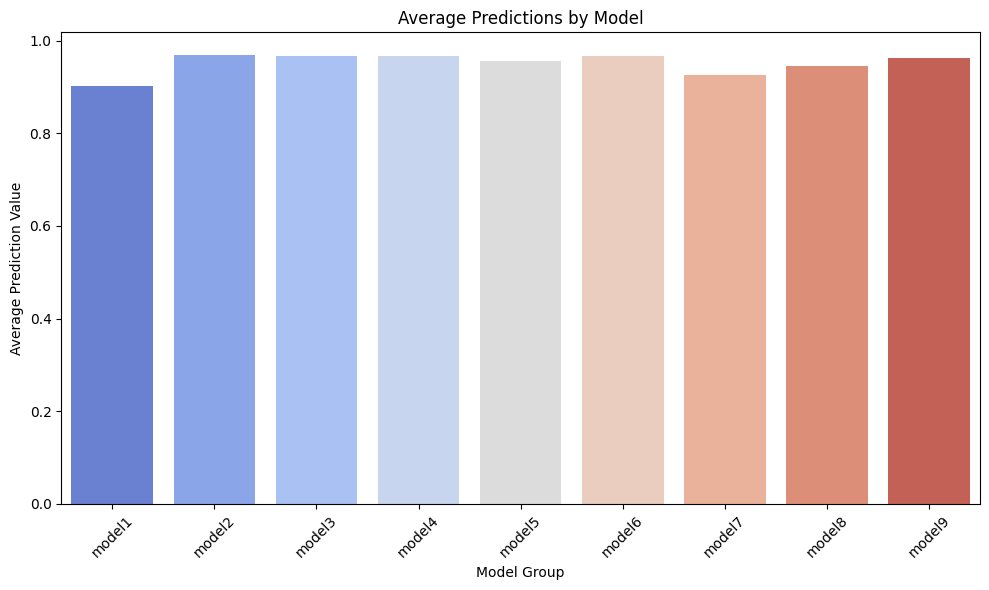

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 모델별로 평균 예측값 계산
df['model_group'] = df['model'].str.split('_').str[0]  # 모델 그룹 추출
mean_predictions = df.groupby('model_group')['prediction'].mean().reset_index()

# Seaborn을 이용한 시각화 (모델 그룹별 평균)
plt.figure(figsize=(10, 6))
sns.barplot(x='model_group', y='prediction', data=mean_predictions, palette='coolwarm')
plt.xticks(rotation=45)  # x축 레이블을 약간 회전
plt.title('Average Predictions by Model')
plt.ylabel('Average Prediction Value')
plt.xlabel('Model Group')
plt.tight_layout()

# 그래프 보여주기
plt.show()
